In [272]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from scipy.optimize import minimize      
import seaborn as sns   
sns.set()

import warnings                                  
warnings.filterwarnings('ignore')

%matplotlib inline

In [291]:
def format_data(data, column_name='Motor speed', 
                start='2020-03-09 00:00:00', 
                end='2020-03-10 16:00:00'):
    
    """
        data - dataset with timeseries
        column_name - Motor parameter name
        start - reference point for deleting data from the source dataset
        end - the endpoint for deleting data from the source dataset
    """
    
    data = pd.read_csv('datasets/AI_M061202_SD.csv', header=None)
    data = data[[0,2]]
    data.columns = ['datetime', 'Motor speed']
    ts_index = pd.to_datetime(data['datetime'])
    data = pd.DataFrame(data['Motor speed'].values, index=ts_index, columns=[column_name])
    data = data.loc[start:end]
    data = data.resample('T').ffill()
    
    return data

In [183]:
data = format_data('datasets/AI_SD.csv')
data.head()

,Motor speed
datetime,
2020-03-09 00:00:00,382
2020-03-09 00:01:00,382
2020-03-09 00:02:00,382
2020-03-09 00:03:00,382
2020-03-09 00:04:00,382


In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2401 entries, 2020-03-09 00:00:00 to 2020-03-10 16:00:00
Freq: T
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Motor speed  2401 non-null   int64
dtypes: int64(1)
memory usage: 37.5 KB


In [126]:
data.describe()

,Motor speed
count,2401.000000
mean,382.202416
std,0.752115
min,365.000000
25%,382.000000
50%,382.000000
75%,382.000000
max,384.000000


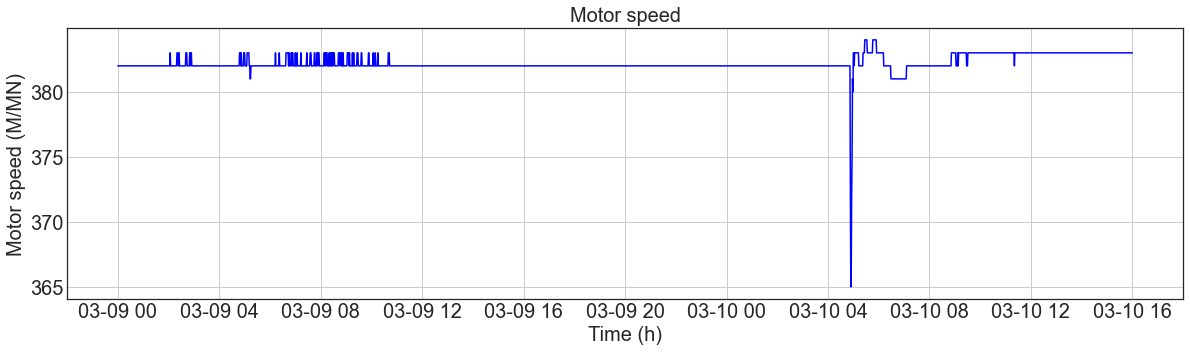

In [127]:
with plt.style.context('seaborn-white'):
    
    plt.figure(figsize=(20, 5))
    plt.tick_params(axis='both', which='major', labelsize=20)

    plt.title("Motor speed", fontsize=20)
    plt.tick_params(labelsize=20)
    plt.xlabel('Time (h)', fontsize=20)
    plt.ylabel('Motor speed (M/MN)', fontsize=20)
    plt.plot(data, color='blue')
    plt.axis('tight')
    plt.grid(True)

# Box-plot

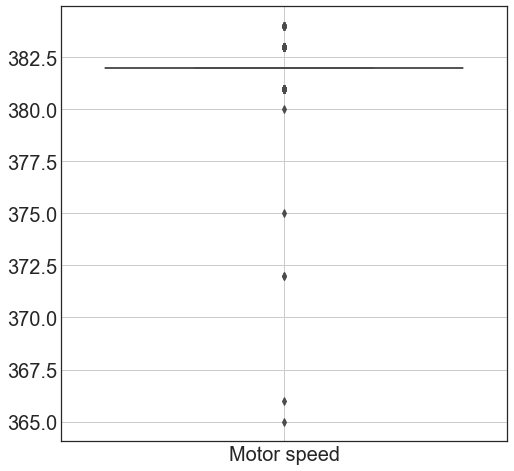

In [128]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8,8))
    plt.tick_params(axis='both', which='major', labelsize=20)
    ax = sns.boxplot(data=data, color='red')
    plt.grid(True)

# 3 sigma

In [292]:
def detect_outliers(data):
    
    """
        data - dataset with timeseries
    """
    
    outliers=[]
    threshold=3
    mean = np.mean(data)
    std  = np.std(data)
    
    for i in data:
        z_score = (i-mean)/std
        if np.abs(z_score) > 3:
            outliers.append(i)
    
    return outliers

In [131]:
data_3s = data.copy(deep=True)
anomalies_do = detect_outliers(data_3s['Motor speed'])
data_3s['Anomalies_DO'] = data_3s['Motor speed'].isin(anomalies_do).astype(int)

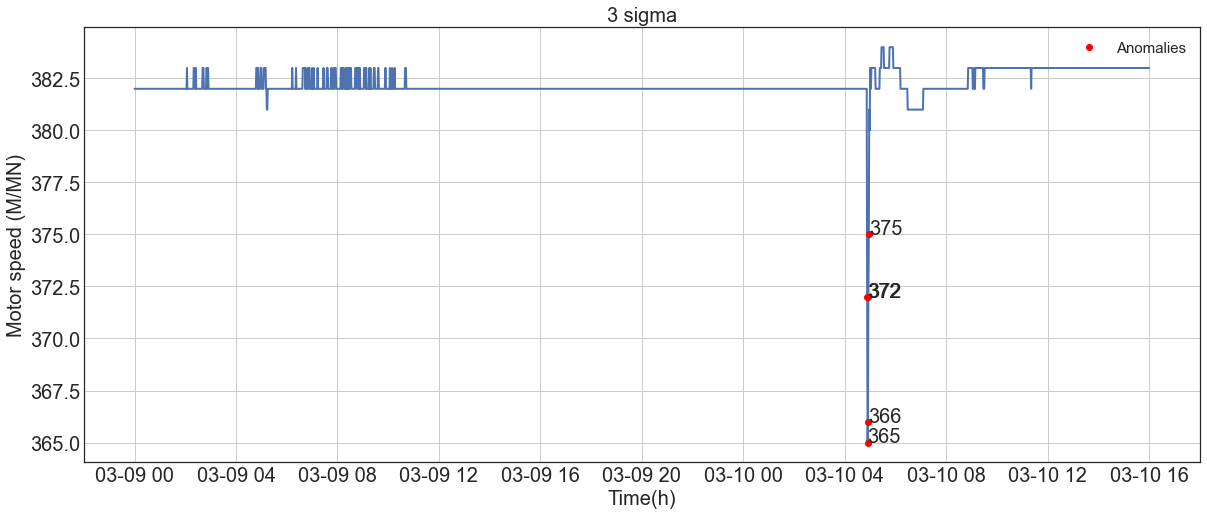

In [133]:
with plt.style.context('seaborn-white'):
    
    plt.figure(figsize=(20,8))
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.title('3 sigma', fontsize=20)
    plt.xlabel('Time(h)', fontsize=20)
    plt.ylabel('Motor speed (M/MN)', fontsize=20)
    plt.plot(data_3s['Motor speed'], linewidth=2)
    plt.plot(data_3s[data_3s['Anomalies_DO'] == 1]['Motor speed'], 'ro', color='red', label='Anomalies')
    plt.axis('tight')
    plt.legend(loc="best", fontsize=15);
    
    for x, y in zip(data_3s[data_3s['Anomalies_DO'] == 1]['Motor speed'].index, 
               list(data_3s[data_3s['Anomalies_DO'] == 1]['Motor speed'])):
        
        label = "{}".format(y)

        plt.annotate(label, (x, int(label)), fontsize=20)
        
    plt.grid(True)
    plt.show()

In [175]:
data_3s[data_3s['Anomalies_DO'] == 1]

,Motor speed,Anomalies_DO
datetime,,
2020-03-10 04:53:00,372,1
2020-03-10 04:54:00,365,1
2020-03-10 04:55:00,366,1
2020-03-10 04:56:00,372,1
2020-03-10 04:57:00,375,1


# Control chart

In [134]:
def chewart_chart(data, number_of_samples=96):
    
    """
        data - dataset with timeseries
        number_of_samples - the number of samples required 
                            to build a Shewhart chart
    """
    
    main_plot = []
    ucl = [] # upper control limit
    lcl = [] # lower control limit
    sample = np.array_split(data.values, number_of_samples)
    
    for i in sample:
        sample_1 = i.mean()
        sample_2 = 3*np.std(i)
        sample_3 = -3*np.std(i)
        sample_4 = sample_2 + sample_1
        sample_5 = sample_3 + sample_1
        main_plot.append(sample_1)
        ucl.append(sample_4)
        lcl.append(sample_5)
        
    ucl = data.values.mean() + 3 * np.std(data.values)
    lcl = data.values.mean() - 3 * np.std(data.values)
    ucl_2 = data.values.mean() + 2 * np.std(data.values)
    lcl_2 = data.values.mean() - 2 * np.std(data.values)
    
    return main_plot[0], ucl, lcl, ucl_2, lcl_2, main_plot

In [135]:
main, ucl, lcl, ucl_2, lcl_2, k = chewart_chart(data['Motor speed'], number_of_samples=96)

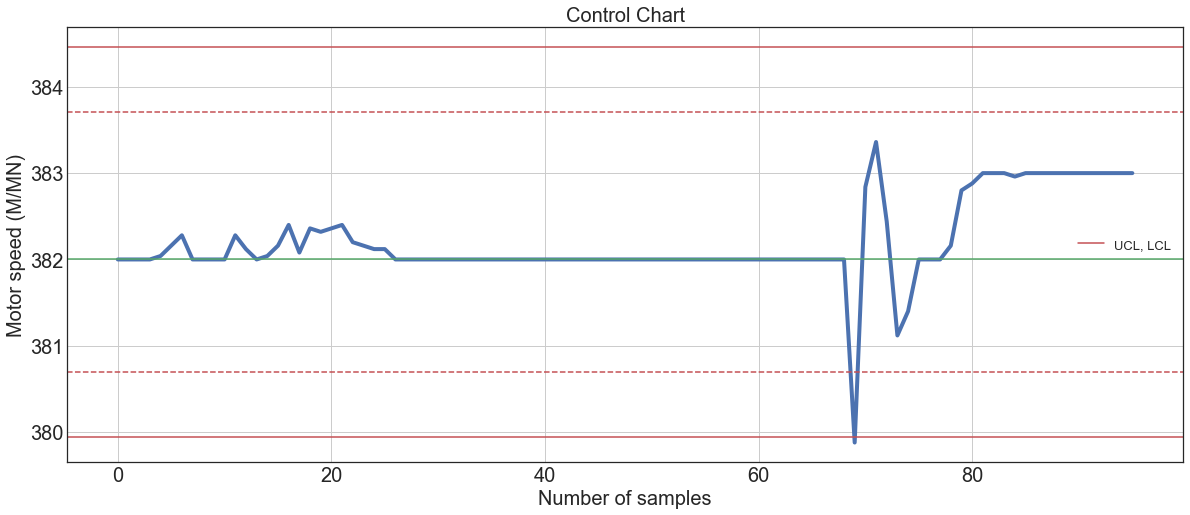

In [136]:
with plt.style.context('seaborn-white'):
    
    plt.figure(figsize=(20,8))
    plt.tick_params(axis='both', which='major', labelsize=20)
    
    plt.title('Control Chart', fontsize=20)

    plt.xlabel('Number of samples', fontsize=20)
    plt.ylabel('Motor speed (M/MN)', fontsize=20)
    plt.plot(k, linewidth=4)
    plt.axhline(ucl, color='r', linestyle='-', label='UCL, LCL')
    plt.axhline(lcl, color='r', linestyle='-')
    plt.axhline(main, color='g', linestyle='-')
    plt.axhline(ucl_2, color='r', linestyle='--')
    plt.axhline(lcl_2, color='r', linestyle='--')
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    plt.grid(True)
    plt.show()

# Local Outlier Factor

In [293]:
def lof(data, n_neighbors=20):
    
    """
        data - dataset with timeseries
        n_neighbors - the number of neighbors considered
    
    """
    
    LOF = LocalOutlierFactor(n_neighbors=n_neighbors)
    data_lof = pd.DataFrame(LOF.fit_predict(data), index=data.index, columns=['Anomalies'])
    data['Anomalies'] = data_lof['Anomalies']
    
    return data

In [279]:
%%time
data_lof = lof(data.copy(deep=True))
data_lof[data_lof['Anomalies'] == -1].head()

Wall time: 135 ms


,Motor speed,Anomalies
datetime,,
2020-03-10 04:53:00,372,-1
2020-03-10 04:54:00,365,-1
2020-03-10 04:55:00,366,-1
2020-03-10 04:56:00,372,-1
2020-03-10 04:57:00,375,-1


In [208]:
data_lof['Anomalies'].value_counts()

 1    2380
-1      21
Name: Anomalies, dtype: int64

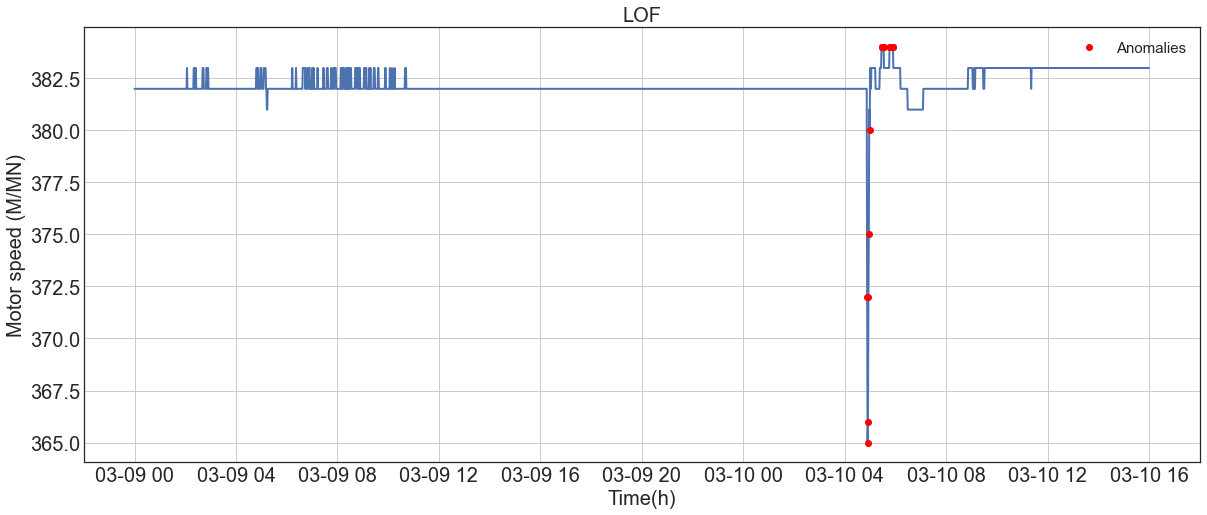

In [233]:
with plt.style.context('seaborn-white'):
    
    plt.figure(figsize=(20,8))
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.title('LOF', fontsize=20)
    plt.xlabel('Time(h)', fontsize=20)
    plt.ylabel('Motor speed (M/MN)', fontsize=20)
    plt.plot(data['Motor speed'], linewidth=2)
    plt.plot(data_lof[data_lof['Anomalies'] == -1]['Motor speed'], 'ro', color='red', label='Anomalies')
    plt.axis('tight')
    plt.legend(loc="best", fontsize=15) 
    plt.grid(True)
    plt.show()

# OneClassSVM

In [226]:
def svm(data, nu=0.1):
    
    """
        data - dataset with timeseries
        nu - an upper bound on the fraction of training 
            errors and a lower bound of the fraction of support vectors
    """
    
    model = OneClassSVM(nu=nu).fit(data)
    y_preds = model.predict(data)
    data_svm = pd.DataFrame(y_preds, index=data.index, columns=['Anomalies'])
    data['Anomalies'] = data_svm['Anomalies']
    
    return data

In [280]:
%%time
data_svm = svm(data.copy(deep=True))
data_svm.head()

Wall time: 78.8 ms


,Motor speed,Anomalies
datetime,,
2020-03-09 00:00:00,382,1
2020-03-09 00:01:00,382,1
2020-03-09 00:02:00,382,1
2020-03-09 00:03:00,382,1
2020-03-09 00:04:00,382,1


In [228]:
data_svm['Anomalies'].value_counts()

 1    2340
-1      61
Name: Anomalies, dtype: int64

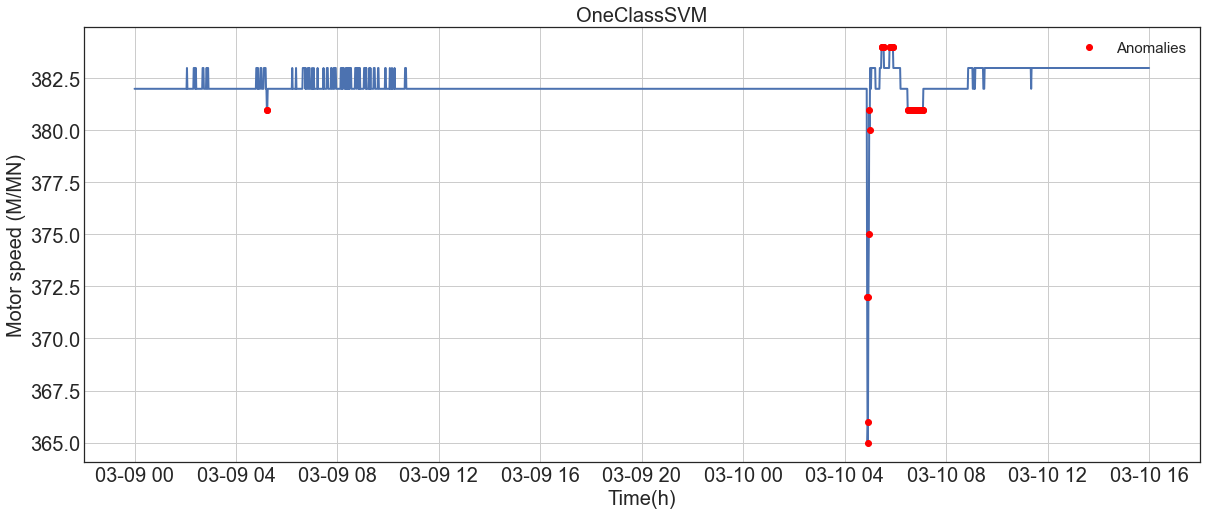

In [234]:
with plt.style.context('seaborn-white'):
    
    plt.figure(figsize=(20,8))
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.title('OneClassSVM', fontsize=20)
    plt.xlabel('Time(h)', fontsize=20)
    plt.ylabel('Motor speed (M/MN)', fontsize=20)
    plt.plot(data['Motor speed'], linewidth=2)
    plt.plot(data_svm[data_svm['Anomalies'] == -1]['Motor speed'], 'ro', color='red', label='Anomalies')
    plt.axis('tight')
    plt.legend(loc="best", fontsize=15) 
    plt.grid(True)
    plt.show()

# Isolation Forest



In [222]:
def iso_forest(data, n_estimators=100, contamination=0.01,
              max_features=0.01, bootstrap=True):
    
    """
        data - dataset with timeseries
        n_estimators - the number of base estimators in the ensemble
        contamination - The amount of contamination of the data set, 
                        i.e. the proportion of outliers in the data set. 
                        Used when fitting to define 
                        the threshold on the scores of the samples
        max_features -  the number of features to draw 
                        from X to train each base estimator
        bootstrap - If True, individual trees 
                    are fit on random subsets of the training 
                    data sampled with replacement. 
                    If False, sampling without replacement is performed.
    """
    
    model = IsolationForest(n_estimators=n_estimators, 
                            contamination=contamination, 
                            max_features=max_features, 
                            bootstrap=bootstrap).fit(data)
    
    y_preds = model.predict(data)
    data_iso = pd.DataFrame(y_preds, index=data.index, columns=['Anomalies'])
    data['Anomalies'] = data_iso['Anomalies']
    
    return data

In [281]:
%%time
data_iso = iso_forest(data.copy(deep=True))
data_iso.head()

Wall time: 432 ms


,Motor speed,Anomalies
datetime,,
2020-03-09 00:00:00,382,1
2020-03-09 00:01:00,382,1
2020-03-09 00:02:00,382,1
2020-03-09 00:03:00,382,1
2020-03-09 00:04:00,382,1


In [224]:
data_iso['Anomalies'].value_counts()

 1    2380
-1      21
Name: Anomalies, dtype: int64

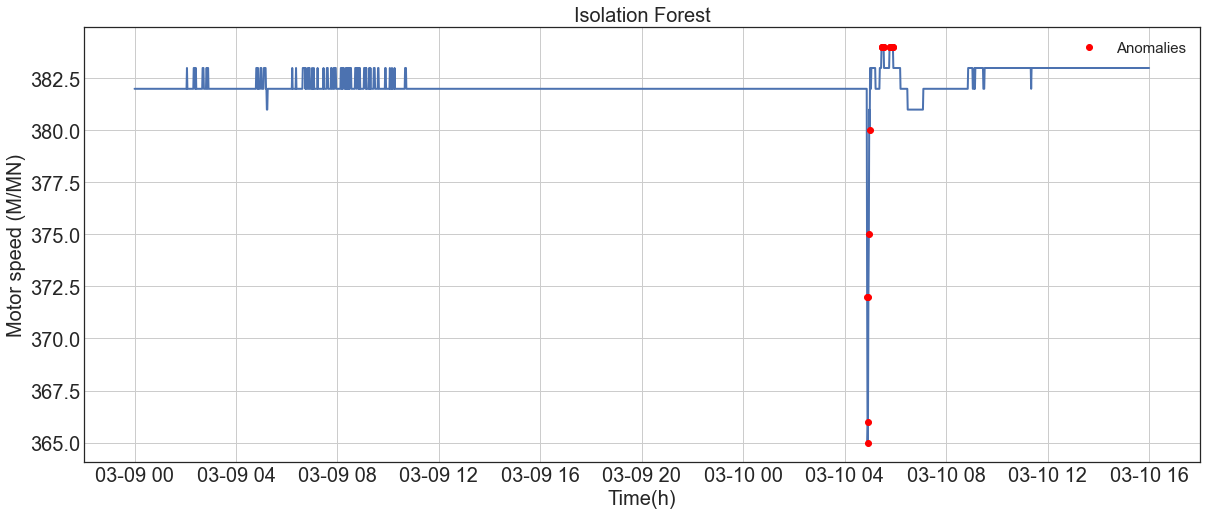

In [235]:
with plt.style.context('seaborn-white'):
    
    plt.figure(figsize=(20,8))
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.title('Isolation Forest', fontsize=20)
    plt.xlabel('Time(h)', fontsize=20)
    plt.ylabel('Motor speed (M/MN)', fontsize=20)
    plt.plot(data['Motor speed'], linewidth=2)
    plt.plot(data_iso[data_iso['Anomalies'] == -1]['Motor speed'], 'ro', color='red', label='Anomalies')
    plt.axis('tight')
    plt.legend(loc="best", fontsize=15) 
    plt.grid(True)
    plt.show()

# DBSCAN

In [230]:
def dbscan(data, eps=0.25):
    
    """
        data - dataset with timeseries
        eps - The maximum distance between two samples 
                for one to be considered as in the neighborhood of the other. 
                This is not a maximum bound on the 
                distances of points within a cluster. 
                This is the most important DBSCAN parameter to choose 
                appropriately for your data set and distance function.
    """
    
    model = DBSCAN(eps=eps).fit(data)
    y_preds = model.fit_predict(data)
    data_dbscan = pd.DataFrame(y_preds, index=data.index, columns=['Anomalies'])
    data['Anomalies'] = data_dbscan['Anomalies']
    
    return data

In [284]:
%%time
data_dbscan = dbscan(data.copy(deep=True))
data_dbscan.head()

Wall time: 327 ms


,Motor speed,Anomalies
datetime,,
2020-03-09 00:00:00,382,0
2020-03-09 00:01:00,382,0
2020-03-09 00:02:00,382,0
2020-03-09 00:03:00,382,0
2020-03-09 00:04:00,382,0


In [232]:
data_dbscan['Anomalies'].value_counts()

 0    1782
 1     558
 2      40
 3      15
-1       6
Name: Anomalies, dtype: int64

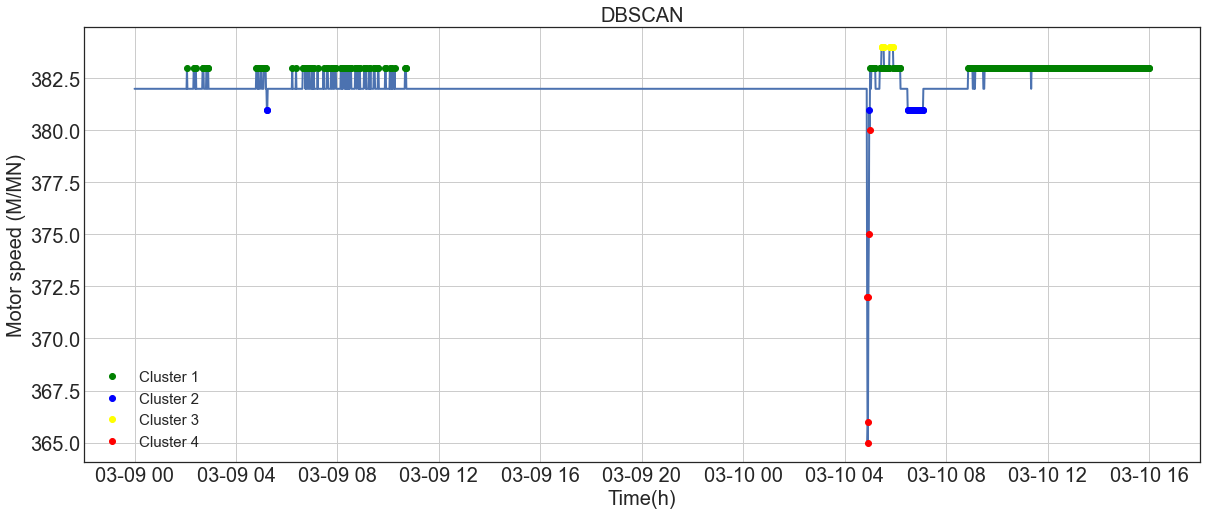

In [237]:
with plt.style.context('seaborn-white'):
    
    plt.figure(figsize=(20,8))
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.title('DBSCAN', fontsize=20)
    plt.xlabel('Time(h)', fontsize=20)
    plt.ylabel('Motor speed (M/MN)', fontsize=20)
    plt.plot(data['Motor speed'], linewidth=2)
    plt.plot(data_dbscan[data_dbscan['Anomalies'] == 1]['Motor speed'], 'ro', color='green', label='Cluster 1')
    plt.plot(data_dbscan[data_dbscan['Anomalies'] == 2]['Motor speed'], 'ro', color='blue', label='Cluster 2')
    plt.plot(data_dbscan[data_dbscan['Anomalies'] == 3]['Motor speed'], 'ro', color='yellow', label='Cluster 3')
    plt.plot(data_dbscan[data_dbscan['Anomalies'] == -1]['Motor speed'], 'ro', color='red', label='Cluster 4') 
    plt.axis('tight')
    plt.legend(loc="best", fontsize=15) 
    plt.grid(True)
    plt.show()

# Model methods

## Linear regression

In [259]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [260]:
data_lr = pd.DataFrame(data['Motor speed'].copy())
data_lr.columns = ["y"]

for i in range(100, 120):
    data_lr["lag_{}".format(i)] = data_lr.y.shift(i)

In [261]:
y = data_lr.dropna().y
X = data_lr.dropna().drop(['y'], axis=1)

In [262]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.9)

In [263]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [296]:
def plotModelResults(model, X_train=X_train, 
                     X_test=X_test, 
                     plot_intervals=False, 
                     plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    plt.figure(figsize=(20, 10))
    plt.tick_params(axis='both', which='major', labelsize=20)
    
    
    plt.title("Изменение скорости двигателя", fontsize=20)
    plt.xlabel('Time (m)', fontsize=20)
    plt.ylabel('Motor speed (M/MN)', fontsize=20)
    
    
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=5, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = rmse(y_test, prediction)
    plt.title("Linear regression", fontsize=20)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

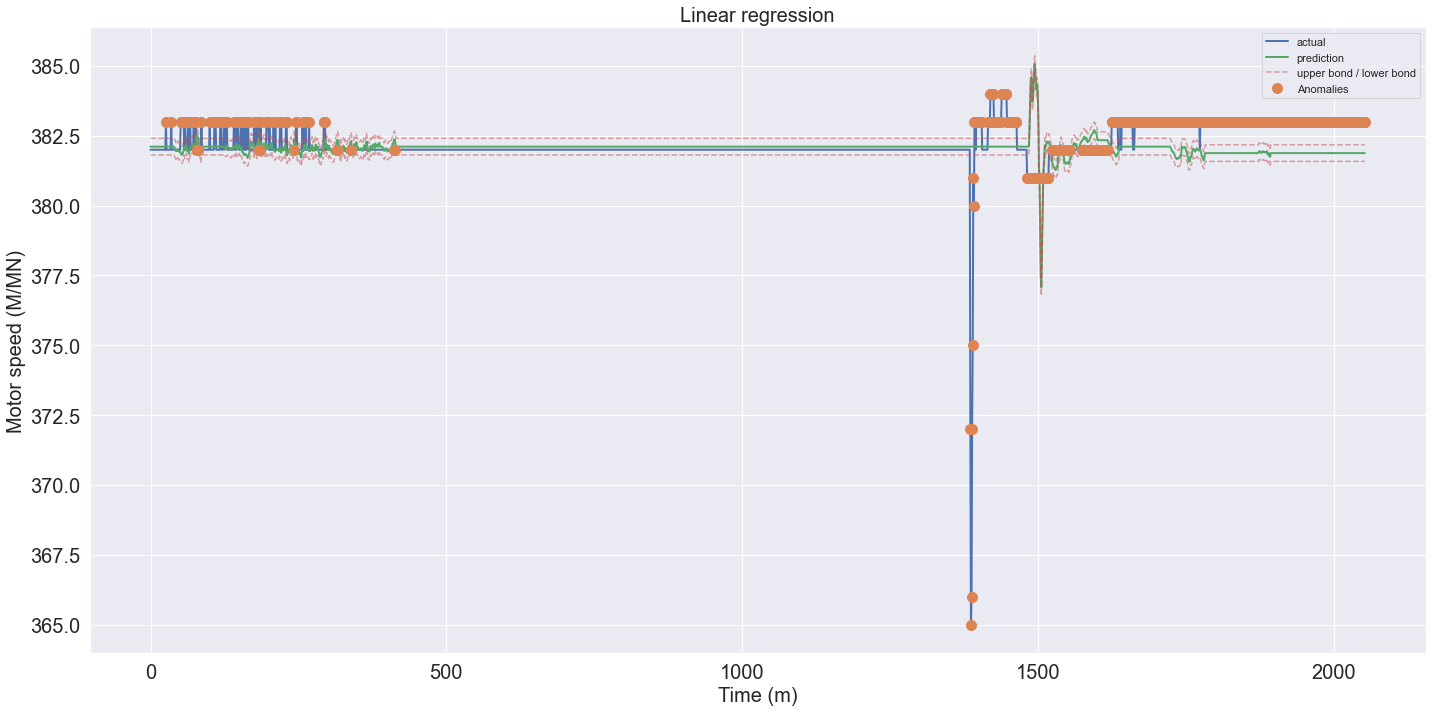

In [297]:
plotModelResults(lr, plot_intervals=True, plot_anomalies=True)